# Import Tensorflow

In [447]:
import tensorflow as tf

# Verifica se há GPUs disponíveis
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detectadas: {gpus}")
    # Testa se a GPU está realmente sendo usada
    print("TensorFlow está utilizando GPU:")
    print(tf.config.list_physical_devices('GPU'))
else:
    print("Nenhuma GPU foi detectada.")

from tensorflow.python.client import device_lib

# Lista todos os dispositivos disponíveis
devices = device_lib.list_local_devices()
for device in devices:
    print(device)


GPUs detectadas: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow está utilizando GPU:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5591907619029269730
xla_global_id: -1

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1722023936
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14183565236600656798
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419



# System Dynamics

In [448]:
import numpy as np

g = 0.5
k = 1.5

def f(t,x):
    if isinstance(x, tf.Tensor):
        e = x[...,0]
        a = x[...,1]
        ca = tf.cos(a)

    else:
        e, a = x
        ca = np.cos(a)
    
    de = -g*e*ca**2.
    da = - k*a

    if isinstance(x, tf.Tensor):
        return tf.stack([de,da],axis=-1)
    else:
        return [de,da]


In [449]:
def polar_to_cartesian(y,yG):
    xG = yG[...,0:2]
    phiG = yG[...,-1]

    phi = - y[...,1] + phiG
    xG = np.array([[0., 0.]])
    x = xG - tf.expand_dims(y[...,0],axis=-1)*tf.stack([tf.cos(y[...,1]),tf.sin(y[...,1])],axis=-1)

    return tf.concat([x,tf.expand_dims(phi,axis=-1)],axis=-1)

# Trajectory Generation

In [450]:
from scipy.integrate import solve_ivp

def generate_trajectory(Tf,Ts,x0):
    teval = np.linspace(0., Tf, int(Tf/Ts))
    sol = solve_ivp(f, [0., Tf], x0, t_eval=teval)
    return sol.t.T, sol.y.T

In [451]:
def generate_dataset(Tf, Ts, N):
    emax = 1.

    e0 = np.random.uniform(1e-3,emax,N)
    a0 = np.random.uniform(-(np.pi - 1e-3),np.pi - 1e-3,N)

    T = []
    X = []
    for i in range(N):
        t, y = generate_trajectory(
            Tf,Ts,
            [e0[i],a0[i]]
        )
        T.append(t)
        X.append(y)
        
    return  tf.cast(tf.expand_dims((tf.stack(T,axis=0)),axis=-1),dtype=tf.float32), \
            tf.cast(tf.stack(X,axis=0),dtype=tf.float32)

# Model Architecture

In [452]:
import tensorflow as tf

class KANLinear(tf.keras.layers.Layer):
    def __init__(self, in_features, out_features):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.scale = self.add_weight(
            shape=(out_features, in_features), 
            initializer=tf.keras.initializers.random_uniform(minval=0.1,maxval=2.,seed=42)
        )
        
        self.translation = self.add_weight(
            shape=(out_features, in_features), 
            initializer=tf.keras.initializers.random_uniform(minval=-0.1,maxval=0.1,seed=42)
        )
        
        self.wavelet_weights = self.add_weight(
            shape=(out_features, in_features),
            initializer=tf.keras.initializers.random_uniform(seed=42)
        )

        # Batch normalization
        # self.bn = tf.keras.layers.BatchNormalization()

    def wavelet_transform(self, y, *args):
        # x is assumed to be (n_batch, sequence_length, n_inputs)
        y_scaled = (tf.expand_dims(y, axis=-2) - (self.translation)) / (self.scale + 1e-3)  # Broadcasting handles dimension alignment

        # Apply the wavelet transformation
        term1 = (y_scaled ** 2) - 1
        term2 = tf.exp(-(y_scaled ** 2)*0.5)
        wavelet = term1 * term2 #* (2 / (math.sqrt(3) * math.pi**0.25))

        # Apply weights and sum along the input features dimension
        wavelet_weighted = wavelet * (self.wavelet_weights)
        wavelet_output = tf.reduce_sum(wavelet_weighted, axis=-1)  # Resulting shape: (n_batch, sequence_length, out_features)

        return wavelet_output

    def call(self, y, *args):
        wavelet_output = self.wavelet_transform(y, *args)
        
        # Apply batch normalization
        # return self.bn(wavelet_output)
        return wavelet_output
    
class FastKAN(tf.keras.Model):
    def __init__(self, layers_hidden):
        super(FastKAN, self).__init__()
        self.layers_list = []

        for in_dim, out_dim in zip(layers_hidden[:-1], layers_hidden[1:]):
            self.layers_list.append(KANLinear(in_dim, out_dim))

    def call(self, t, *args):
        y = tf.concat([t,*args],axis=-1)

        for layer in self.layers_list:
            y = layer(y)
        return y

class TISPIKAN(tf.keras.Model):
    def __init__(self, nstates, nterms, layers_hidden):
        super(TISPIKAN, self).__init__()
        self.kans_list = []
        self.reshape_list = []
        for i in range(nstates):
            self.kans_list.append(FastKAN([1] + layers_hidden[1:-1] + [3*nstates*nterms*layers_hidden[-1]]))
            self.reshape_list.append(tf.keras.layers.Reshape((-1,3,nstates,nterms,layers_hidden[-1])))
        
    def call(self, t, *args):
        y = tf.concat(args,axis=-1)
        
        temp = 1.0
        for i, l in enumerate(zip(self.kans_list,self.reshape_list)):
            kan, reshape = l
            temp = temp*reshape(kan(tf.expand_dims(y[...,i],axis=-1)))
        
        coeffs = tf.reduce_sum(temp,axis=-1)
        w = coeffs[...,0,:,:]
        tau = coeffs[...,1,:,:]
        s = coeffs[...,2,:,:]

        t_scaled = (tf.expand_dims(t,axis=-1) - tau)/(s + 1e-1)
        out = tf.reduce_sum(w*(t_scaled**2 - 1)*tf.exp(-(t_scaled**2)*0.5),axis=-1)
        return out
        

# PINN Cost Function

In [453]:
def loss_function(t, x, model):
    x0 = tf.repeat(tf.expand_dims(x[:,0,:], axis=1), repeats=t.shape[1], axis=1)
    
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([t, x0])
        pred = model(t, x0)
        
        X = [pred[...,i] for i in range(pred.shape[-1])]
    
    DXDT = [tape1.gradient(xi,t) for xi in X]
    dxdt = tf.concat(DXDT, axis=-1)

    err = (x - pred)/tf.abs(x)*100.
    err_d = (f(t,x) - dxdt)/tf.abs(f(t,x))*100.

    L_ic = tf.reduce_mean(tf.norm(err[:,0,:], axis=-1))
    L_bc = tf.reduce_mean(tf.norm(err, axis=-1))
    L_r1 = tf.reduce_mean(tf.norm(err_d, axis=-1))

    return L_ic, L_bc, L_r1

# Training

In [454]:
N = 200
T, X = generate_dataset(10.,50e-3,N)

print(T.shape)
print(X.shape)

(200, 200, 1)
(200, 200, 2)


In [455]:
train_idx = int(0.8*N)
val_idx = train_idx + int(0.1*N)

t = T[:train_idx]
x = X[:train_idx]

tv = T[train_idx:val_idx]
xv = X[train_idx:val_idx]

tt = T[val_idx:]
xt = X[val_idx:]

print(t.shape)
print(x.shape)

print(tv.shape)
print(xv.shape)

print(tt.shape)
print(xt.shape)

(160, 200, 1)
(160, 200, 2)
(20, 200, 1)
(20, 200, 2)
(20, 200, 1)
(20, 200, 2)


In [456]:
from keras import optimizers

model = TISPIKAN(2,10,[3,3])
optimizer = optimizers.Adam(learning_rate=1.e-3)

In [457]:
@tf.function
def train_step(t, x, tv, xv, model, lambdas, reweight=False):
    lambda_ic, lambda_bc, lambda_r1 = lambdas
    lambdas_new = lambdas

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([t] + model.trainable_variables)
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch([t] + model.trainable_variables)
            L_ic, L_bc, L_r1 = loss_function(t, x, model)
            L_ic_v, L_bc_v, L_r1_v = loss_function(tv, xv, model)

            L = lambda_ic*L_ic + lambda_bc*L_bc + lambda_r1*L_r1 
            L_v = lambda_ic*L_ic_v + lambda_bc*L_bc_v + lambda_r1*L_r1_v

        gradients = tape1.gradient(L,  model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        
    if reweight == True:
        grad_L_ic = tape.gradient(L_ic, model.trainable_variables)
        grad_L_bc = tape.gradient(L_bc, model.trainable_variables)
        grad_L_r1 = tape.gradient(L_r1, model.trainable_variables)

        norm_grad_L_ic = tf.sqrt(sum([tf.reduce_mean(tf.square(g)) for g in grad_L_ic if g is not None]))
        norm_grad_L_bc = tf.sqrt(sum([tf.reduce_mean(tf.square(g)) for g in grad_L_bc if g is not None]))
        norm_grad_L_r1 = tf.sqrt(sum([tf.reduce_mean(tf.square(g)) for g in grad_L_r1 if g is not None]))
        
        norm_grad_total = sum([norm_grad_L_ic, norm_grad_L_bc, norm_grad_L_r1])

        lambda_ic = norm_grad_total/norm_grad_L_ic
        lambda_bc = norm_grad_total/norm_grad_L_bc
        lambda_r1 = norm_grad_total/norm_grad_L_r1
    
    lambdas_new = [lambda_ic, lambda_bc, lambda_r1]

    # lambda_max = tf.reduce_max(tf.stack(lambdas_new))
    # lambdas_new = [l/lambda_max for l in lambdas_new]

    return L, L_v, [L_ic, L_bc, L_r1], [L_ic_v, L_bc_v, L_r1_v], lambdas_new
    


In [458]:
lambdas = [tf.constant(el) for el in [1.,1.,1.]]
alpha = 0.9

In [459]:
import time
from math import ceil
import matplotlib.pyplot as plt


start_time = time.time()
losses = []
total_time = 0

cont = 0


In [460]:
S = 300000
s_reweight = 100
partitions = 4.
verbose = 100


In [461]:
while cont <= S:
    idx_t = np.linspace(0,len(t)-1,len(t),dtype=np.int32)
    
    loss = 0
    loss_v = 0
    L = [0.,0.,0.]
    L_v = [0.,0.,0.]

    for j in range(int(partitions)):
        idx_min = j*ceil(len(t)/partitions)
        idx_max = (j+1)*ceil(len(t)/partitions)
        
        if not idx_max < len(t):
            idx_max = len(t)
        
        ti = t[idx_min:idx_max,...]
        xi = x[idx_min:idx_max,...]

        reweight=(((cont + 1) % s_reweight == 0)) | (cont == 0)
        # reweight=(cont == 0)

        li, l_vi, Li, L_vi, lambdas_new = train_step(
            ti, xi, tv, xv, 
            model, lambdas, reweight=reweight
        )
        loss += li/partitions
        loss_v += l_vi/partitions
        L   = [l + e/partitions for (l,e) in zip(L,Li)]
        L_v = [l + e/partitions for (l,e) in zip(L_v,L_vi)]

        if reweight:
            if cont == 0:
                lambdas = [l_n for l_n in lambdas_new]
            else:
                lambdas = [alpha*l + (1.0-alpha)*l_n for (l,l_n) in zip(lambdas,lambdas_new)]

    losses.append([loss, loss_v] + L + L_v)

    if (cont + 1) % verbose == 0:
        print(f"Epoch: {cont + 1}\nLoss: {loss}\nL: {[l.numpy() for l in L]}\nlambdas: {[l.numpy() for l in lambdas]}")
        print(f"Validation: {loss_v}\nL_v: {[l.numpy() for l in L_v]}")
        elapsed_time = time.time() - start_time
        total_time += elapsed_time
        print(f"Elapsed time: {elapsed_time}\n")
        start_time = time.time()
    
    cont += 1


Epoch: 100
Loss: 200514784.0
L: [137.96115, 140.30438, 13879.379]
lambdas: [14949.76, 1207249.5, 1.0021106]
Validation: 201731104.0
L_v: [141.63269, 141.16663, 3822.0469]
Elapsed time: 7.740728378295898

Epoch: 200
Loss: 127381368.0
L: [102.1756, 120.84929, 35240.49]
lambdas: [14202.424, 825285.3, 1.0028373]
Validation: 138956096.0
L_v: [143.4715, 131.22314, 5846.868]
Elapsed time: 5.084592819213867

Epoch: 300
Loss: 80190168.0
L: [82.39703, 111.82672, 22119.14]
lambdas: [11008.021, 549880.7, 1.0049999]
Validation: 89054224.0
L_v: [121.49912, 123.3372, 6052.6772]
Elapsed time: 7.189239263534546

Epoch: 400
Loss: 50649224.0
L: [73.21568, 105.8106, 19148.264]
lambdas: [8305.99, 365064.84, 1.0071158]
Validation: 56812344.0
L_v: [118.14243, 117.723175, 6829.516]
Elapsed time: 7.181780815124512

Epoch: 500
Loss: 32015964.0
L: [68.3344, 100.55117, 17133.443]
lambdas: [6668.1724, 243755.44, 1.008144]
Validation: 35991500.0
L_v: [114.08597, 111.94849, 7040.752]
Elapsed time: 5.669521808624268


KeyboardInterrupt: 

In [ ]:
print(total_time/3600.)

In [ ]:


losses_tf = tf.reshape(losses, [len(losses),-1])

# Criar gráficos para delta e omega
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(np.log10(losses_tf[::1000,0:2]), label='')
plt.subplot(212)
plt.plot(np.log10(losses_tf[::1000,2:]))
plt.xlabel('Tempo (s)')
plt.ylabel('Loss')
plt.grid(True) 

In [ ]:
index = 0

0
(1, 200, 1)
(1, 200, 3)
(1, 200, 3)
(1, 200, 7)
(1, 200, 3)


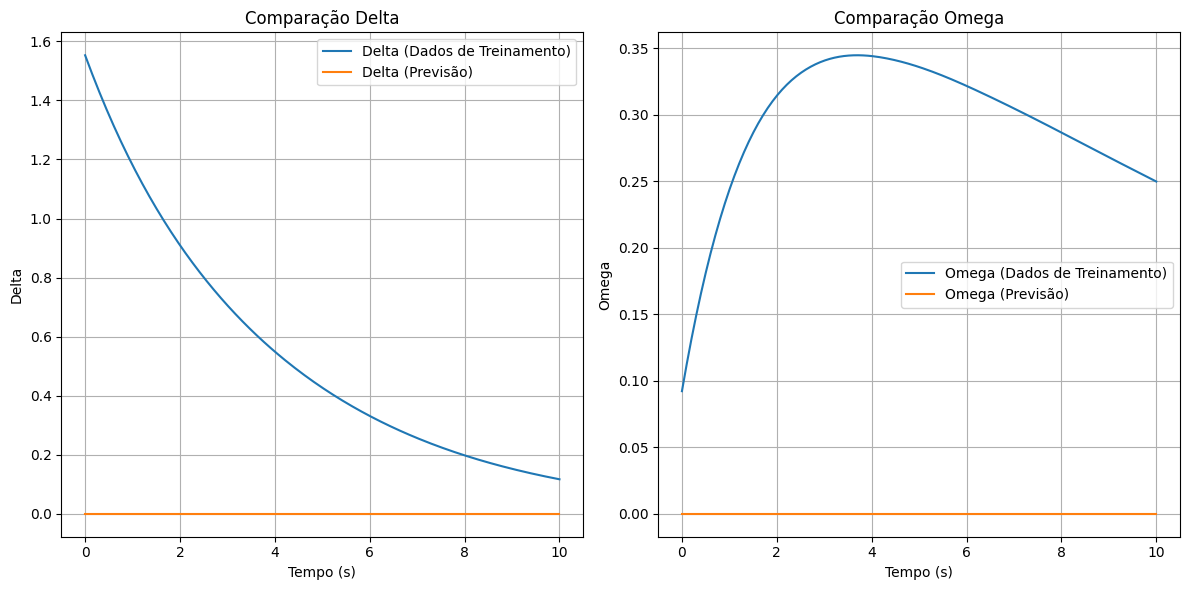

In [ ]:
# Escolha uma trajetória aleatória para comparar
print(index)

t_s = tt[index,...]
t_i = tf.expand_dims(t_s,axis=0)
reps = t_i.shape[1]
x_s = xt[index]
x0_s = tf.expand_dims(tf.tile(tf.expand_dims(xt[index,0,:],axis=0),(reps,1)),axis=0)
ul_s = tf.expand_dims(ut[index,...],axis=0)

print(t_i.shape)
print(x0_s.shape)
print(ul_s.shape)
y = model(t_i,x0_s,ul_s)
print(y.shape)

# Criar gráficos para delta e omega
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(t[index], x_s[:, 0], label='Delta (Dados de Treinamento)')
plt.plot(t[index], y[0,:, 0], label='Delta (Previsão)')
plt.xlabel('Tempo (s)')
plt.ylabel('Delta')
plt.title('Comparação Delta')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(t_s, x_s[:, 1], label='Omega (Dados de Treinamento)')
plt.plot(t_s, y[0,:, 1], label='Omega (Previsão)')
plt.xlabel('Tempo (s)')
plt.ylabel('Omega')
plt.title('Comparação Omega')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

index = index + 1
if index >= len(tv):
    index = 0

In [ ]:
tt_tf = tf.constant(tt)
xt_tf = tf.constant(xt)
ut_tf = tf.constant(ut)
loss_t = loss_function(tt_tf,xt_tf,ut_tf,model)

print([l.numpy() for l in loss_t])

In [ ]:
predictions = []
xi = tf.expand_dims(xt[:,0,:],axis=1)
print(len(tt[0,:,0]))
print(xi.shape)
for i in range(10):

    pred = model(tt,tf.repeat(xi,len(tt[0,:,0]),axis=1),tf.repeat(tf.expand_dims(ut,axis=1),len(tt[0,:,0]),axis=1))
    predictions.append(pred)
    xi = tf.expand_dims(pred[:,-1,:],axis=1)

X = tf.concat(predictions,axis=1)

In [ ]:
index = 1

In [ ]:
print(index)

predictions = []
xi = tf.expand_dims(xt[:,0,:],axis=1)
print(len(tt[0,:,0]))
print(xi.shape)
for i in range(10):

    pred = model(tt,tf.repeat(xi,len(tt[0,:,0]),axis=1),tf.repeat(tf.expand_dims(ut,axis=1),len(tt[0,:,0]),axis=1))
    predictions.append(pred)
    xi = tf.expand_dims(pred[:,-1,:],axis=1)

X = tf.concat(predictions,axis=1)

tRef, Xref = generate_trajectory(1., 1e-3, xt[index,0,:], u[index,:])

# Criar gráficos para delta e omega
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(tRef, Xref[:, 0], label='Delta (Dados de Treinamento)')
plt.plot(tRef, X[index,:,0], label='Delta (Previsão)')
plt.xlabel('Tempo (s)')
plt.ylabel('Delta')
plt.title('Comparação Delta')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(tRef, Xref[:, 1], label='Omega (Dados de Treinamento)')
plt.plot(tRef, X[index,:,1], label='Omega (Previsão)')
plt.xlabel('Tempo (s)')
plt.ylabel('Omega')
plt.title('Comparação Omega')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

index = index + 1
if index >= len(xt[:,0,0]):
    index = 0